In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
import torch
from sae_lens import SAE
from neuronpedia.np_sae_feature import SAEFeature
import configs
import json

In [2]:
def load_regression_weights(layer, use_sae, pickle_dir='pickles/regression_weights', brain_region='broca'):
    model_name = 'gemma2BSAE' if use_sae else 'gemma2B'
    filepath = os.path.join(pickle_dir, f'{brain_region}_{model_name}_L{layer}.pkl')
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data


In [3]:
model_layer = 12
use_sae = True

In [4]:
data = load_regression_weights(model_layer, use_sae)

In [5]:
W_llm_to_brain = data['best_estimator'].named_steps['ridge'].coef_


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
release = "gemma-scope-2b-pt-res-canonical"
sae_id = f"layer_{model_layer}/width_16k/canonical"
sae = SAE.from_pretrained(release, sae_id)[0].to(device)

In [7]:
W_llm_to_brain.shape

(193, 9216)

In [8]:
W_dec = sae.W_dec.detach().cpu().numpy()

In [9]:
W_features_to_llm = np.repeat(W_dec, 4, axis=1)
W_features_to_llm.shape

(16384, 9216)

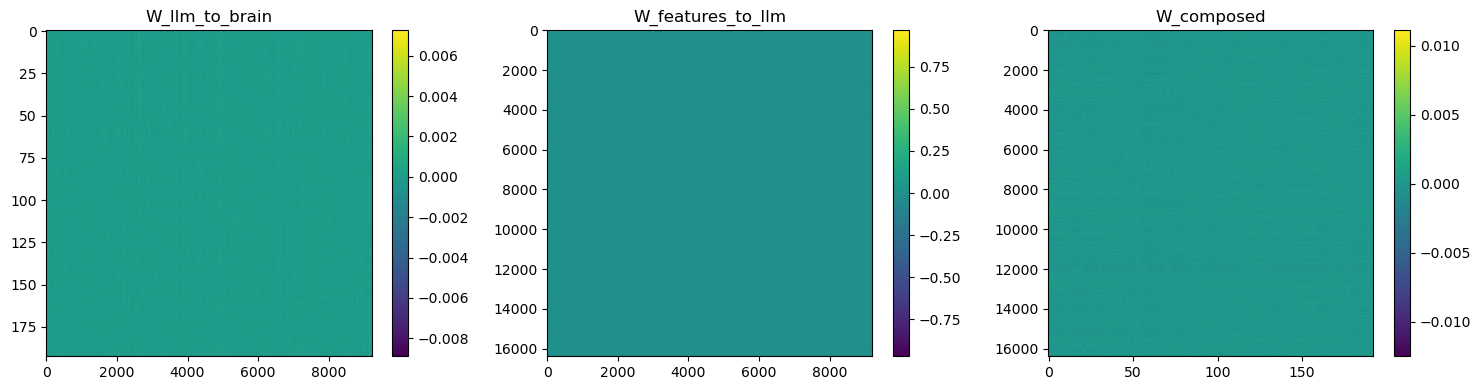

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot W_llm_to_brain
im1 = ax1.imshow(W_llm_to_brain, aspect='auto')
ax1.set_title('W_llm_to_brain')
plt.colorbar(im1, ax=ax1)

# Plot W_features_to_llm 
im2 = ax2.imshow(W_features_to_llm, aspect='auto')
ax2.set_title('W_features_to_llm')
plt.colorbar(im2, ax=ax2)

# Plot matrix multiplication
W_composed = W_features_to_llm @ W_llm_to_brain.T
im3 = ax3.imshow(W_composed, aspect='auto')
ax3.set_title('W_composed')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()


In [11]:
W_composed.shape

(16384, 193)

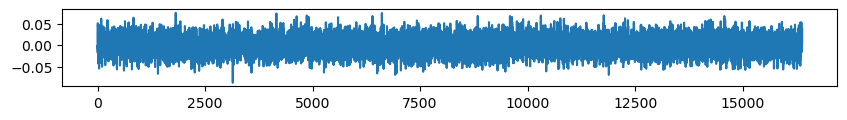

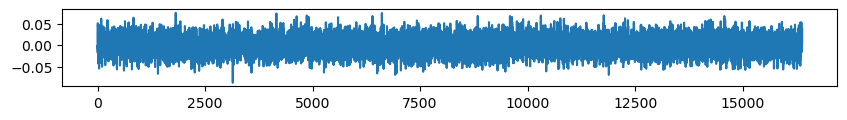

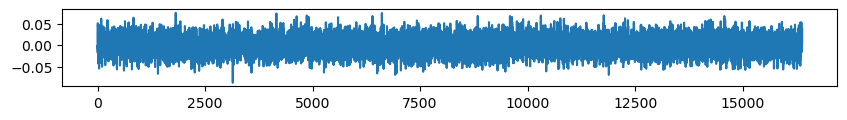

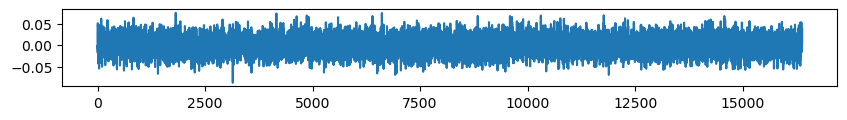

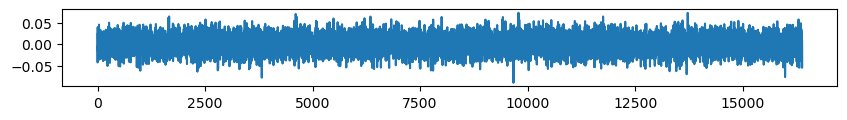

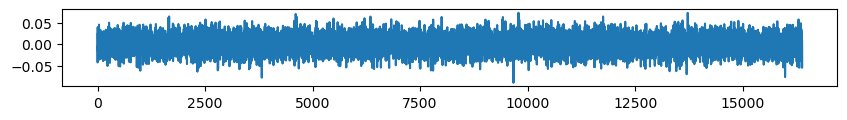

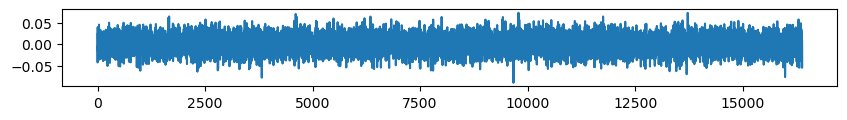

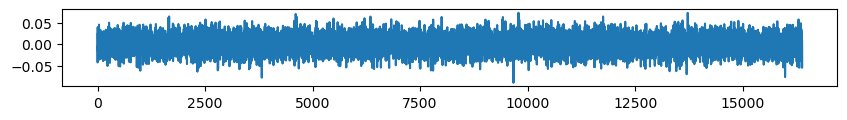

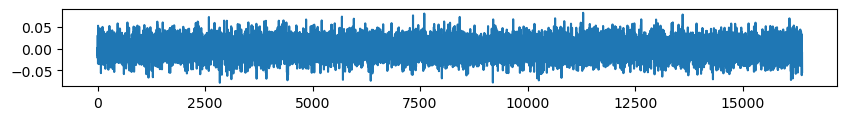

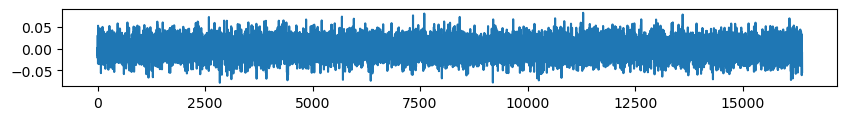

In [12]:
for unit in range(10):
    plt.figure(figsize=(10, 1))
    plt.plot(W_features_to_llm[:,unit])
    plt.show()


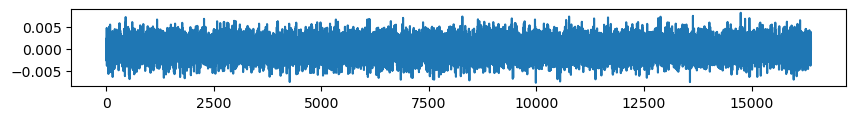

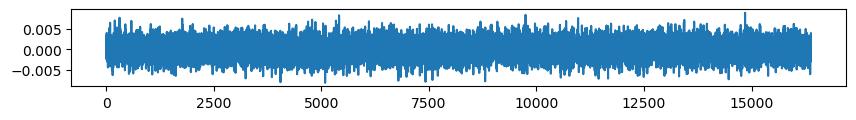

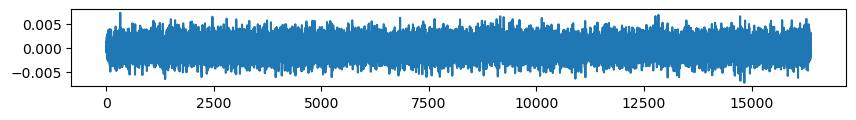

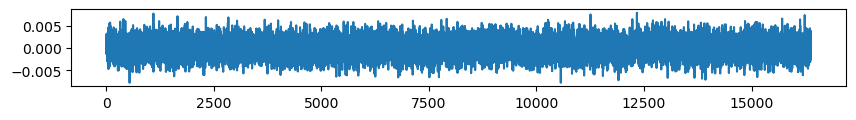

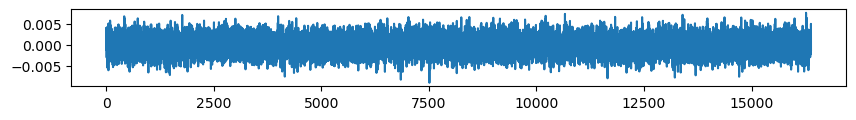

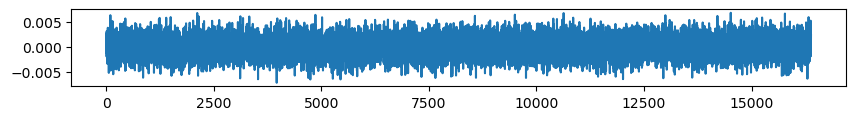

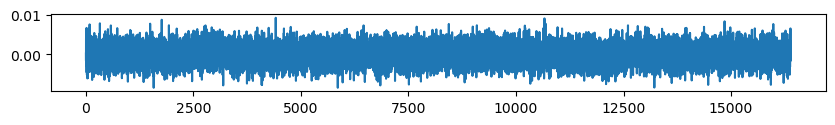

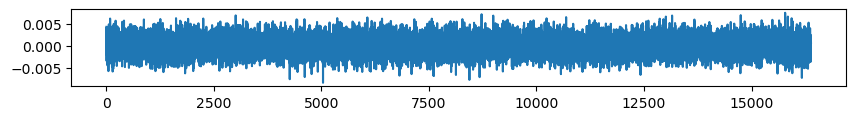

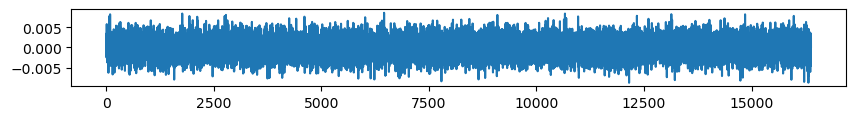

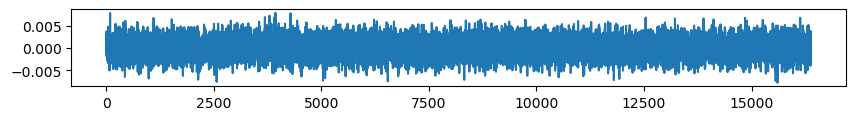

In [13]:
for voxel in range(10):
    plt.figure(figsize=(10, 1))
    plt.plot(W_composed[:,voxel])
    plt.show()

In [14]:
threshold = np.percentile(W_composed.flatten(), 99.9)
print(threshold)

0.006372457550941908


In [15]:
np.sum(W_composed[:,0] > threshold)

23

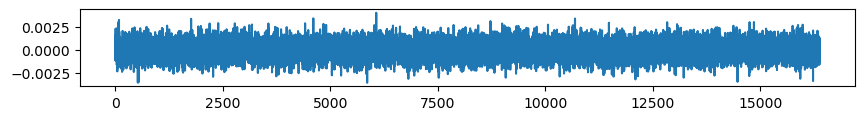

In [16]:
mean_loading = W_composed.mean(axis=1)
plt.figure(figsize=(10, 1))
plt.plot(mean_loading)
plt.show()


In [17]:
np.sum(mean_loading > 0.003)

10

In [20]:
top_indices = np.argsort(mean_loading)[-30:][::-1]  # Get indices of top 30 values in descending order
print("Top 30 feature indices by mean loading:")
print(np.sort(top_indices))

Top 30 feature indices by mean loading:
[   64    85  1762  2192  2392  2779  3114  3176  3559  4413  4604  4840
  4902  6022  6067  7866  8438  8723  8995  9047 10061 10639 10689 11478
 12832 13062 14749 14850 15875 15983]


In [21]:
descriptions = []
for feature_index in top_indices:
    print(feature_index)
    sae_feature = SAEFeature.get("gemma-2-2b", "12-gemmascope-res-16k", f"{feature_index}")
    feature_info = json.loads(sae_feature.jsonData)
    this_feature_info = ''
    for idx, i in enumerate(feature_info['explanations']):
        this_feature_info += i['description']
        if idx < len(feature_info['explanations']) - 1:
            this_feature_info += ' OR '
    descriptions.append(this_feature_info)

6067
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/6067
Got a successful response.
4604
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/4604
Got a successful response.
10689
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/10689
Got a successful response.
1762
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/1762
Got a successful response.
85
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/85
Got a successful response.
8723
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/8723
Got a successful response.
14850
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/14850
Got a successful response.
14749
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k

In [22]:
for description in descriptions:
    print(description)
    print()

references to children or childhood-related terminology

references to legal codes and procedural rules

 phrases related to ongoing discussions or clarifications about issues or situations

 coding language elements and structures

 functions and state manipulations in programming code

 keywords related to Android intents and their functionalities

references to geographical locations and environmental features associated with Tibet

phrases and terms related to objectives or goals

metrics and statistical measures in scientific data

comparative phrases and expressions indicating similarity or equality

 terms related to mobile devices and their functionalities

instances or uses of the word "literally" and its variations

 various forms of punctuation and special characters

code-related keywords and syntax elements used in programming

 technical code syntax and structure

 terms related to evaluation and evolution

references or citations within the text

instances of the term "w